In [6]:
from LSTMCell import LSTM
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


In [8]:
from data_creation import get_trajectories
%load_ext autoreload
%autoreload 2

sol = get_trajectories()

x,y,vx,vy,t = sol

print((x.shape))

(3, 21317)


In [9]:
import numpy as np


# Applied sigmoid but does not seem to do much
# We can first try without sigmoid


# custom function
def sigmoid(x):
  return 1 / (1 + np.exp(-x))


# define vectorized sigmoid
sigmoid_v = np.vectorize(sigmoid)

# # test
x_sig = sigmoid(x)  
y_sig = sigmoid(y)
vx_sig = sigmoid(vx)
vy_sig = sigmoid(vy)




In [10]:
import numpy as np
import pandas as pd

data = np.vstack((x, y, vx, vy)).T
data2 = np.vstack((x_sig, y_sig, vx_sig, vy_sig)).T

def remove_outliers(data):
    # Compute quartiles along each column (dimension)
    Q1 = np.percentile(data, 25, axis=0)
    Q3 = np.percentile(data, 75, axis=0)
    IQR = Q3 - Q1
    
    # Define the upper and lower limits for each dimension
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    
    # Use np.clip to cap values per dimension
    capped_data = np.clip(data, lower_limit, upper_limit)
    
    return capped_data
print(data2.shape)
data3 = remove_outliers(data2)
print(data3.shape)

(21317, 12)
(21317, 12)


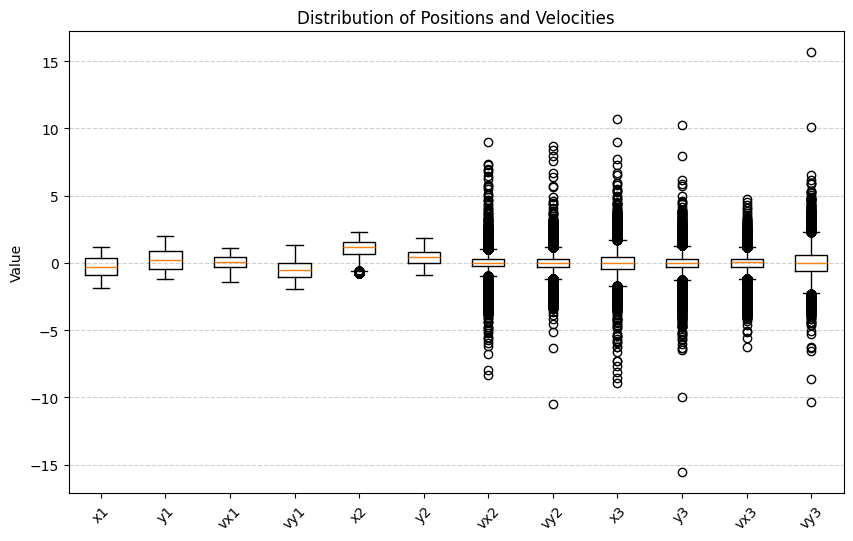

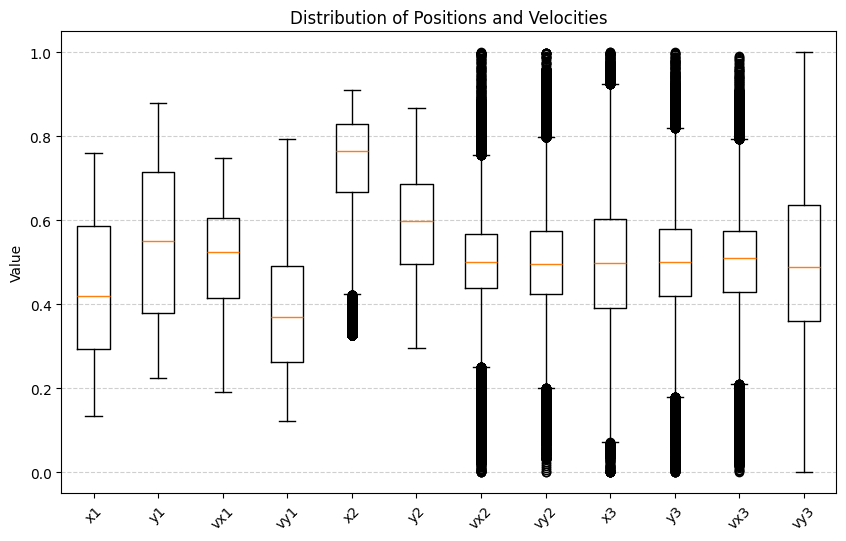

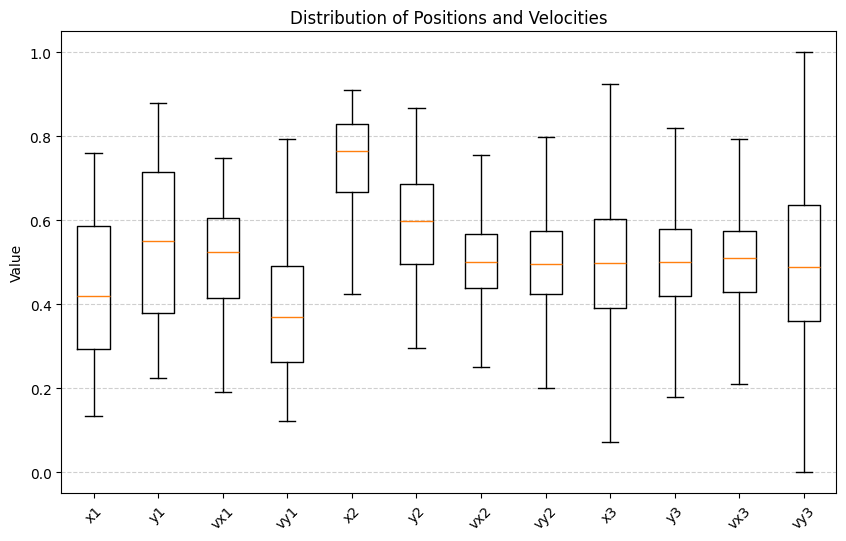

In [27]:
# data visualizations
from data_creation import plot_trajectories, plot_boxplots, plot_velocity_magnitude

plot_boxplots(data)
plot_boxplots(data2)
plot_boxplots(data3)
# plot_velocity_magnitude(data)
# plot_trajectories(data)

In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, RobustScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense

In [14]:
from data_creation import transform_data
sliding_window = 10
forecast_horizon = 10
X_train, y_train, X_test, y_test, scaler = transform_data(data3, window_size=sliding_window, test_size=0.2, forecast_horizon=forecast_horizon)

# Convert to DataFrame
df = pd.DataFrame(X_test[:,-1,:], columns=[f"col_{i}" for i in range(X_test[:,-1,:].shape[1])])

# Save to Excel
df.to_excel("output.xlsx", index=False)

df = pd.DataFrame(y_test, columns=[f"col_{i}" for i in range(y_test.shape[1])])

# Save to Excel
df.to_excel("output2.xlsx", index=False)



(21317, 12)


In [22]:
from LSTMCell import LSTM
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

input_window_size = 12
hidden_size = 32
num_layers = 2

model = LSTM(input_window_size, hidden_size, num_layers)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
num_epochs = 20
losses, val_loss = model.training_loop_cv(
    num_epochs = num_epochs, 
    criterion = criterion,
    optimizer = optimizer,
    trainX = X_train,
    trainY = y_train
)



Fold 1
Epoch [1/20], Train Loss: 0.6927, Val Loss: 0.4528
Epoch [2/20], Train Loss: 0.6770, Val Loss: 0.4478
Epoch [3/20], Train Loss: 0.6564, Val Loss: 0.4402
Epoch [4/20], Train Loss: 0.6112, Val Loss: 0.4223
Epoch [5/20], Train Loss: 0.4951, Val Loss: 0.4229
Epoch [6/20], Train Loss: 0.4365, Val Loss: 0.4106
Epoch [7/20], Train Loss: 0.3905, Val Loss: 0.3919
Epoch [8/20], Train Loss: 0.3426, Val Loss: 0.3738
Epoch [9/20], Train Loss: 0.3022, Val Loss: 0.3583
Epoch [10/20], Train Loss: 0.2669, Val Loss: 0.3428
Epoch [11/20], Train Loss: 0.2363, Val Loss: 0.3281
Epoch [12/20], Train Loss: 0.2118, Val Loss: 0.3152
Epoch [13/20], Train Loss: 0.1924, Val Loss: 0.3045
Epoch [14/20], Train Loss: 0.1768, Val Loss: 0.2960
Epoch [15/20], Train Loss: 0.1645, Val Loss: 0.2894
Epoch [16/20], Train Loss: 0.1544, Val Loss: 0.2840
Epoch [17/20], Train Loss: 0.1458, Val Loss: 0.2792
Epoch [18/20], Train Loss: 0.1382, Val Loss: 0.2752
Epoch [19/20], Train Loss: 0.1315, Val Loss: 0.2717
Epoch [20/20],

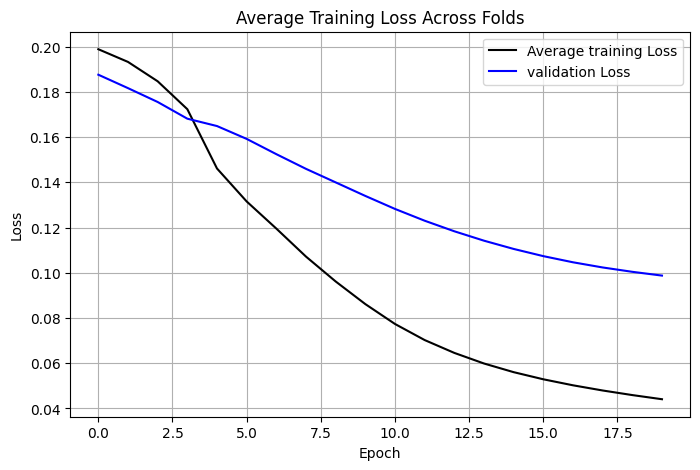

In [33]:

max_len = num_epochs

# ensure sub arrays are of the same length by padding with -1
losses_array = np.array([
    lst + [-1] * (max_len - len(lst)) if len(lst) < max_len else lst[:max_len]
    for lst in losses
])
# compute average ignoring -1 values
avg_loss = np.mean(losses_array, axis=0, where=(losses_array != -1))

# ensure sub arrays are of the same length by padding with -1
losses_array_val = np.array([
    lst + [-1] * (max_len - len(lst)) if len(lst) < max_len else lst[:max_len]
    for lst in val_loss
])
# compute average ignoring -1 values
avg_val_loss = np.mean(losses_array_val, axis=0, where=(losses_array_val != -1))

plt.figure(figsize=(8, 5))
plt.plot(avg_loss, color='black', label='Average training Loss')
plt.plot(avg_val_loss, color='blue', label='validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Training Loss Across Folds')
plt.grid(True)
plt.legend()
plt.show()

Generate time series from 1 input and plot both in one plot

### Save model

In [34]:
import time

timestamp = time.strftime("%Y%m%d-%H%M%S")
filename = f"models/model_{timestamp}.pt"

torch.save(model, filename)
print(f"Model saved to {filename}")

Model saved to models/model_20251017-194538.pt


### Load model

In [1]:
import os
model_path = ""

if os.path.exists(model_path):
    print("Loading saved model...")
    model = torch.load(model_path)

c:\Users\Wout Teillers\Documents\AI\Master\Year1\1a\Advanced_machine_learning\Code\venv\lib\site-packages\torch\nn\modules\loss.py:616: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([1, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0.018935181200504303
0.018933571875095367
0.018931956961750984
0.018930351361632347
0.018928756937384605
0.018927166238427162
0.018925590440630913
0.018924010917544365
0.018922442570328712
0.018920889124274254
0.021340923383831978


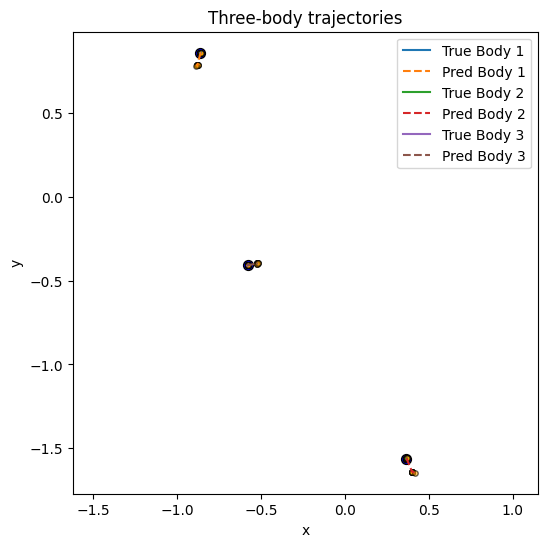

In [2]:
from data_creation import plot_trajectories
steps = 10


generated = X_test[:19]  # TODO make this dynamical based of sliding window size
generated = generated[:, 0, :]

output = model.generate_timeseries(steps=steps, generated=generated, Y_test=y_test, criterion=criterion, sliding_window_size=sliding_window)

# remove middle dimension
X_test_selected = X_test[:, 0, :]

plot_trajectories(X_test_selected[0:steps+19], output)

### Grid search

In [ ]:
from itertools import product
import torch
import os
import pandas as pd

# define the grid search parameters
param_grid = {'num_layers': [2, 4, 8],
              'optimizer': ['Adam'], #'SGD', 'RMSprop', for now only Adam
              'learning_rate': [0.01, 0.001, 0.0001],
              #'window_size': [10, 50, 100],
              'hidden_size': [32, 64, 128],
              #'forecast_horizon': [1, 10, 100]
              }


# generate combinations
keys = list(param_grid.keys())
combinations = [dict(zip(keys, values)) for values in product(*param_grid.values())]
print(f"Total combinations to try: {len(combinations)}")
print(f"If training takes half an hour per combination, this will take {len(combinations)*0.5:.2f} hours, which is {len(combinations)*0.5/24:.2f} days.")

results_path = "grid_search_results.csv"
if os.path.exists(results_path):
    results_df = pd.read_csv(results_path)
else:
    results_df = pd.DataFrame(columns=keys + ["val_loss"])

best_val_loss = results_df["val_loss"].min() if not results_df.empty else float('inf')
best_params = None
best_model_state = None

for combo in combinations:
    mask = (results_df[list(combo.keys())] == pd.Series(combo)).all(axis=1)
    if mask.any():
        print(f"Skipping already completed combo: {combo}")
        continue

    print(f"Training with combo: {combo}")


    model = LSTM(input_window_size=12,
                 hidden_size=combo['hidden_size'],
                 num_layers=combo['num_layers'])
    
    if combo['optimizer'] == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=combo['learning_rate'])
    elif combo['optimizer'] == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=combo['learning_rate'], weight_decay=1e-4)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=combo['learning_rate'])
    
    criterion = nn.MSELoss()

    num_epochs = 20
    losses, val_loss = model.training_loop_cv(
        num_epochs=num_epochs,
        criterion=criterion,
        optimizer=optimizer,
        trainX=X_train,
        trainY=y_train
    )

    final_val_loss = np.average(val_loss[-1])

    # save result immediately
    results_df.loc[len(results_df)] = {**combo, "val_loss": final_val_loss}
    results_df.to_csv(results_path, index=False)

    if final_val_loss < best_val_loss:
        best_val_loss = final_val_loss
        best_params = combo
        best_model_state = model.state_dict()

print(f"Best combo: {best_params} with val loss: {best_val_loss:.4f}")
torch.save(best_model_state, "best_lstm_model.pt")
print("Best model saved to best_lstm_model.pt")

Total combinations to try: 27
If training takes half an hour per combination, this will take 13.50 hours, which is 0.56 days.
Training with combo: {'num_layers': 2, 'optimizer': 'Adam', 'learning_rate': 0.01, 'hidden_size': 32}
Fold 1
Epoch [1/20], Train Loss: 0.6176, Val Loss: 0.7145
Epoch [2/20], Train Loss: 0.4719, Val Loss: 0.5042
Epoch [3/20], Train Loss: 0.3458, Val Loss: 0.4015
Epoch [4/20], Train Loss: 0.2344, Val Loss: 0.3184
Epoch [5/20], Train Loss: 0.1511, Val Loss: 0.3667
Epoch [6/20], Train Loss: 0.1289, Val Loss: 0.3317
Epoch [7/20], Train Loss: 0.1028, Val Loss: 0.3344
Early stopping triggered
Fold 2
Epoch [1/20], Train Loss: 0.2167, Val Loss: 0.4050
Epoch [2/20], Train Loss: 0.2645, Val Loss: 0.4351
Epoch [3/20], Train Loss: 0.2438, Val Loss: 0.3792
Epoch [4/20], Train Loss: 0.2037, Val Loss: 0.3705
Epoch [5/20], Train Loss: 0.1873, Val Loss: 0.3173
Epoch [6/20], Train Loss: 0.1982, Val Loss: 0.4399
Epoch [7/20], Train Loss: 0.1682, Val Loss: 0.3251
Epoch [8/20], Train

KeyboardInterrupt: 